# Setup

## Imports

In [4]:
using Pkg
Pkg.activate("SCC", shared=true)

import QuantumToolbox as qt
import SuperconductingCavities as SC
import CairoMakie as cm
using Revise
using Dates
import JSON3

using YAXArrays

using ProgressMeter

import Optim as opt

using Logging
using MiniLoggers

using IJulia
if isdefined(Main, :IJulia)
   Main.IJulia.stdio_bytes[] = 0;
end


  Activating project at `~/.julia/environments/SCC`


0

## Logger Setups

In [5]:
# MiniLogger(minlevel = MiniLoggers.Info) |> global_logger
InfoLogger = MiniLogger(minlevel = MiniLoggers.Info)
ProgressLogger = MiniLogger(minlevel = LogLevel(-1))
DebugLogger = MiniLogger(minlevel = MiniLoggers.Debug)

global_logger(ProgressLogger)

Base.CoreLogging.SimpleLogger(VSCodeServer.IJuliaCore.IJuliaStdio{Base.PipeEndpoint, typeof(VSCodeServer.io_send_callback)}(IOContext(Base.PipeEndpoint(RawFD(18) open, 0 bytes waiting)), VSCodeServer.io_send_callback), Info, Dict{Any, Int64}())

# Loading Data

In [70]:
modes = [1,2,3,4,5,6,7,8,9,10];
losses = ["None", "All", "CC", "TC", "TD"];
drive_errors = ["LL", "L", "HL", "None", "HU", "U", "UU"];

In [71]:
models = Dict{Any, Any}()

for i in modes
    models[i] = SC.Circuits.Transmon_Resonators.load("ModelSaves/Mode$(i)/Mode$(i).json")
end

In [130]:
for i in modes
    println("Mode $(i):\n   Accuracy: $(models[i].Stuff["op_drive_params"]["sb_f0g1"]["accuracy"])\n   Drive Time: $(models[i].Stuff["op_drive_params"]["sb_f0g1"]["pulse_time"])\n   ε: $(models[i].Stuff["op_drive_params"]["sb_f0g1"]["epsilon"])\n   freq: $(models[i].Stuff["op_drive_params"]["sb_f0g1"]["freq_d"]+models[i].Stuff["op_drive_params"]["sb_f0g1"]["shift"])\n   stark shift: $(models[i].Stuff["op_drive_params"]["sb_f0g1"]["shift"])")
end

Mode 1:
   Accuracy: 0.9999094644409078
   Drive Time: 338.25935369473007
   ε: 0.295
   freq: -3.3338187085895417
   stark shift: 0.01524592951607475
Mode 2:
   Accuracy: 0.9994114023332887
   Drive Time: 204.92182562001517
   ε: 0.595
   freq: -3.0670149085917284
   stark shift: 0.037204608786014504
Mode 3:
   Accuracy: 0.9996045058377755
   Drive Time: 205.05411739244443
   ε: 0.735
   freq: -2.832297683870131
   stark shift: 0.037664663557229916
Mode 4:
   Accuracy: 0.9996803590800175
   Drive Time: 220.40941624060824
   ε: 0.84
   freq: -2.58524529514708
   stark shift: 0.0329644387960523
Mode 5:
   Accuracy: 0.9995273278704916
   Drive Time: 197.0997733929405
   ε: 1.21
   freq: -2.3306940213241765
   stark shift: 0.04653811211348203
Mode 6:
   Accuracy: 0.9999892934177311
   Drive Time: 378.9353606773365
   ε: 0.7705
   freq: -2.1220674163637794
   stark shift: 0.013630770587593845
Mode 7:
   Accuracy: 0.9999296120853679
   Drive Time: 291.2202399349962
   ε: 1.22
   freq: -1.85

In [73]:
data_dict = Dict{Any, Any}()

for combo in Iterators.product(modes, losses, drive_errors)
    key = "Mode"*string(combo[1])*"_Loss_"*string(combo[2])*"_DE_"*string(combo[3])
    data_dict[key] = SC.Utils.LoadRunResults("Data/f0g1_Error_Budget/"*key*".nc")
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 

# Making A Plot! 

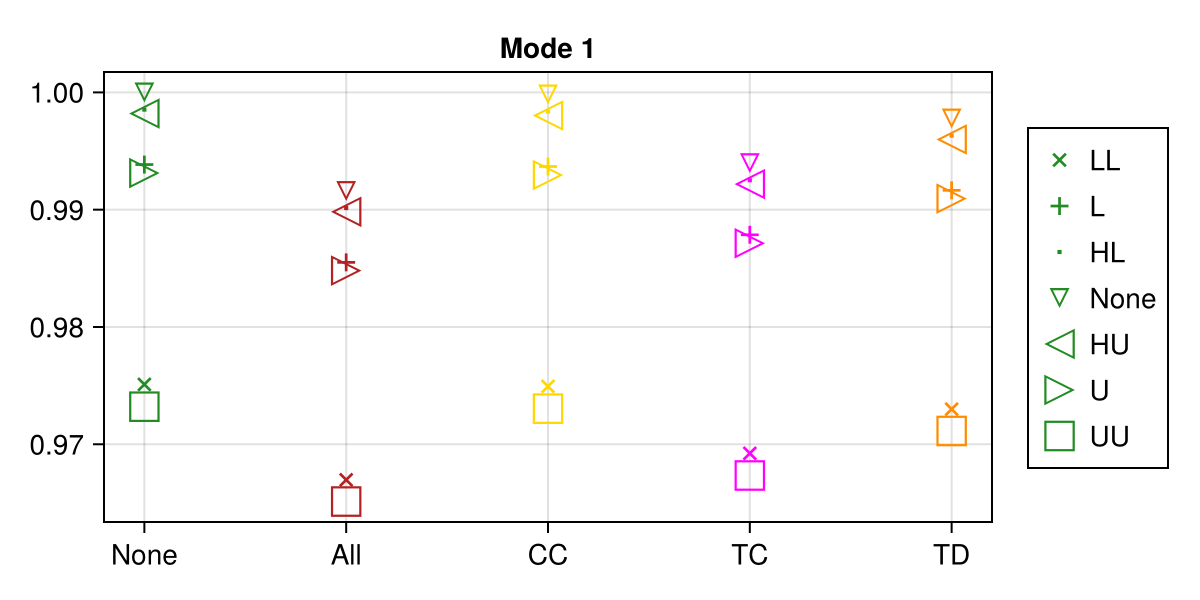

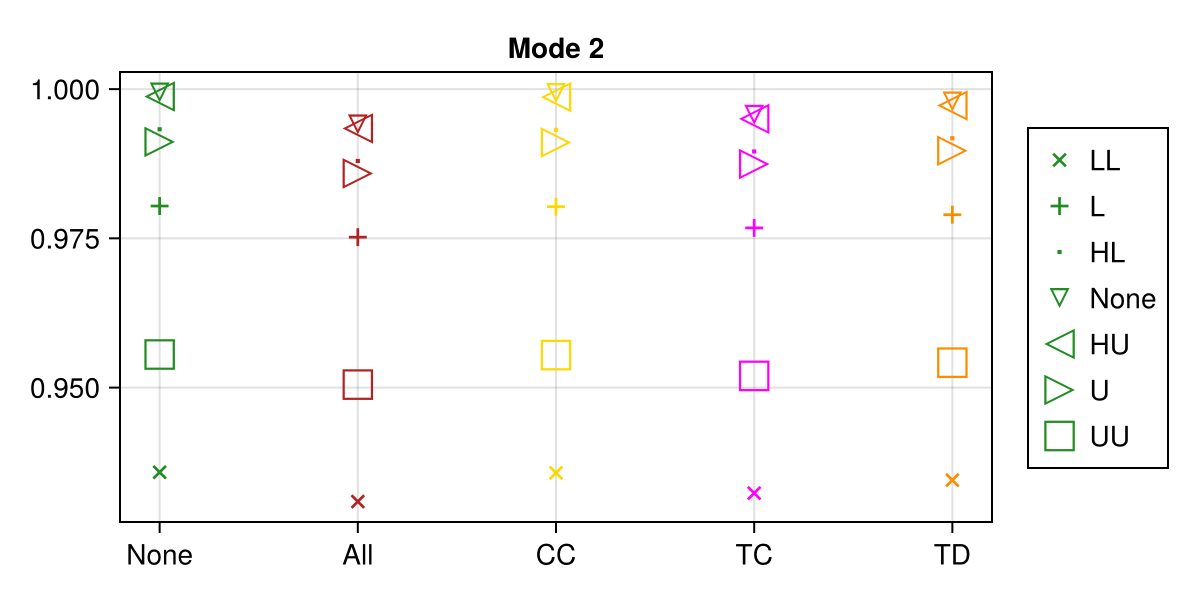

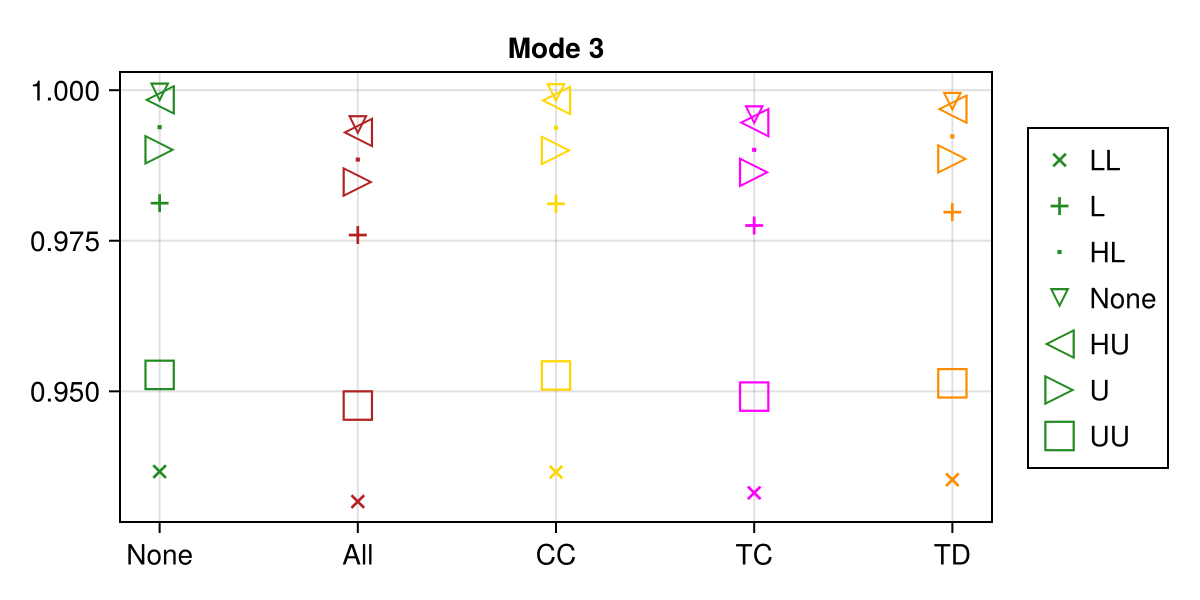

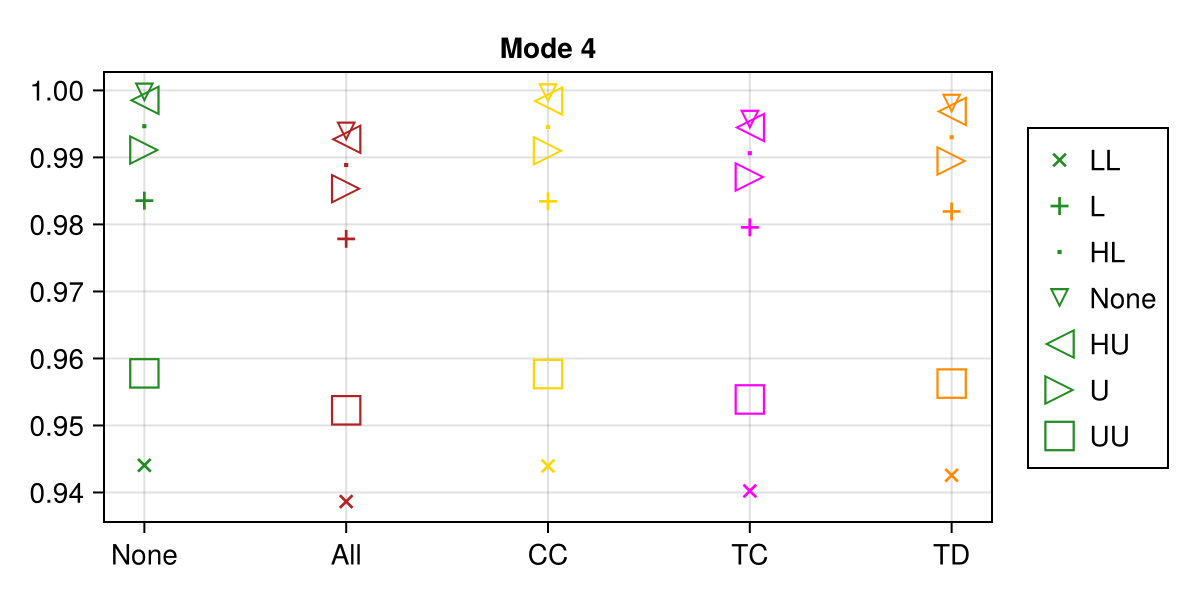

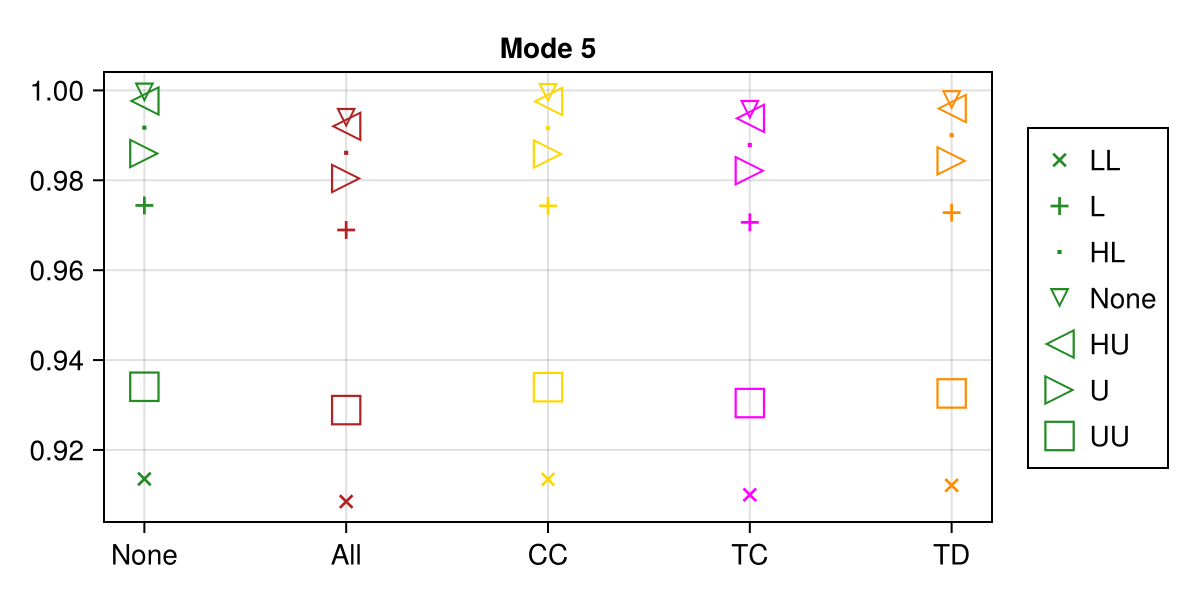

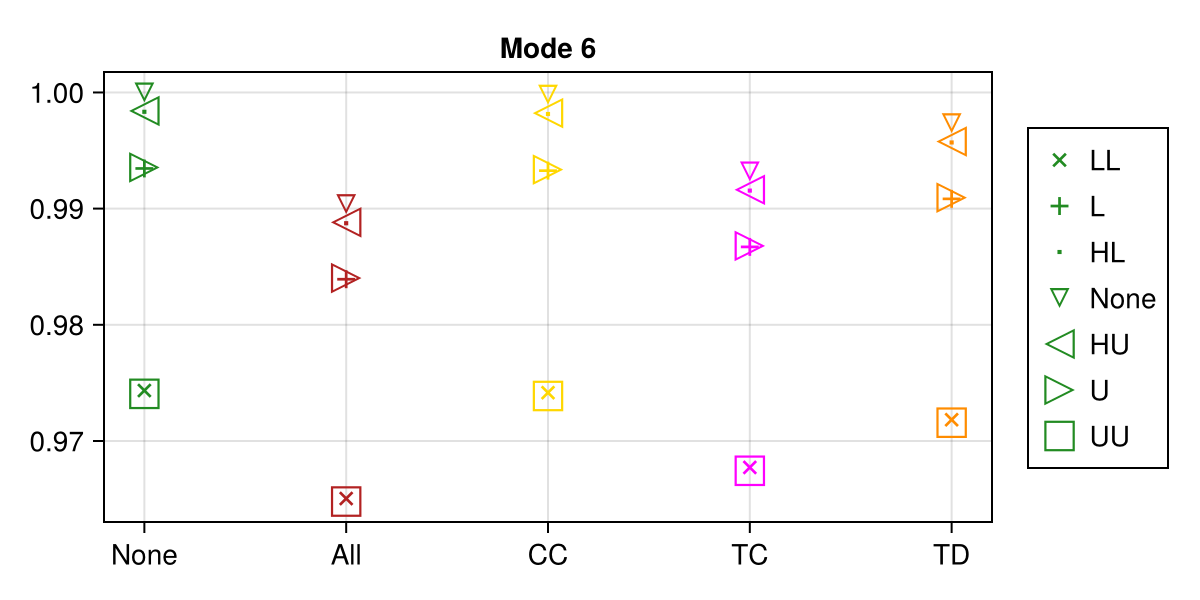

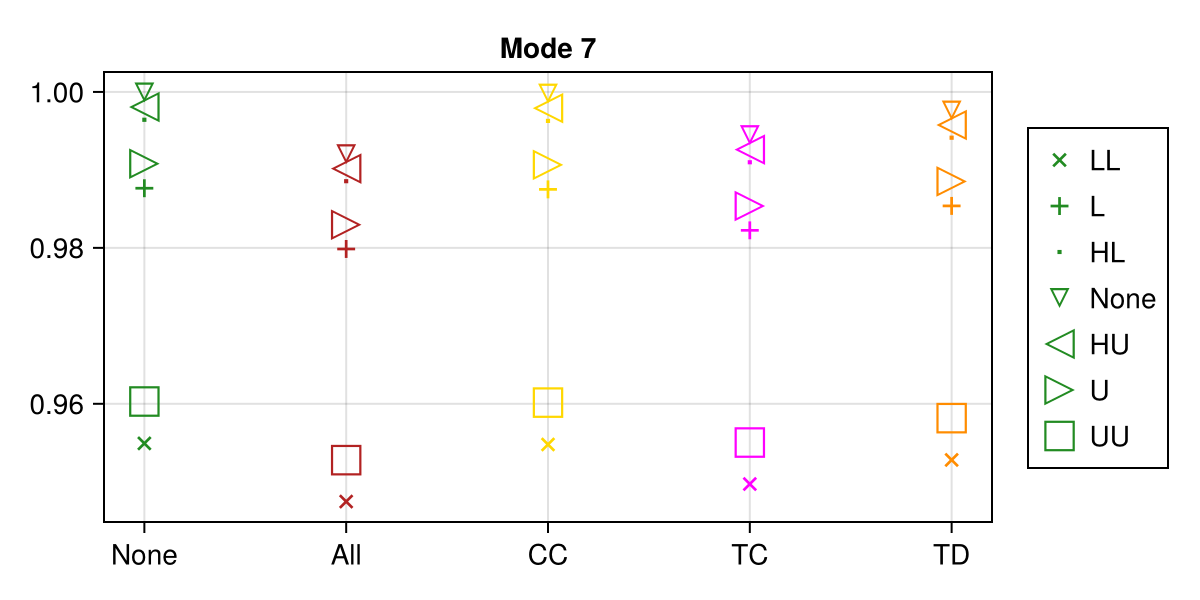

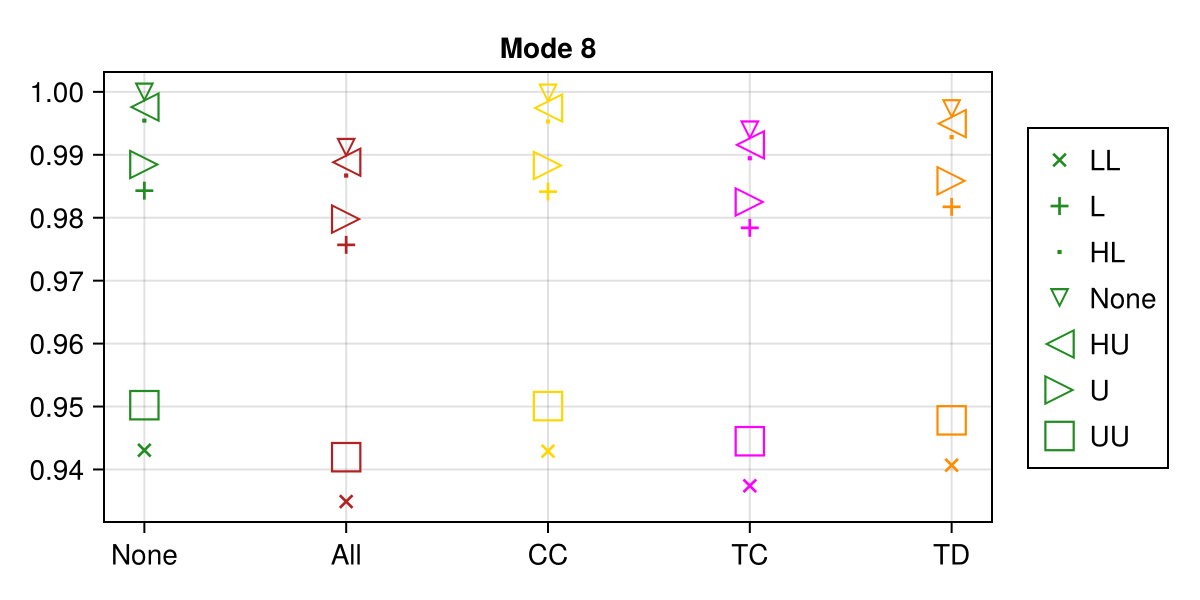

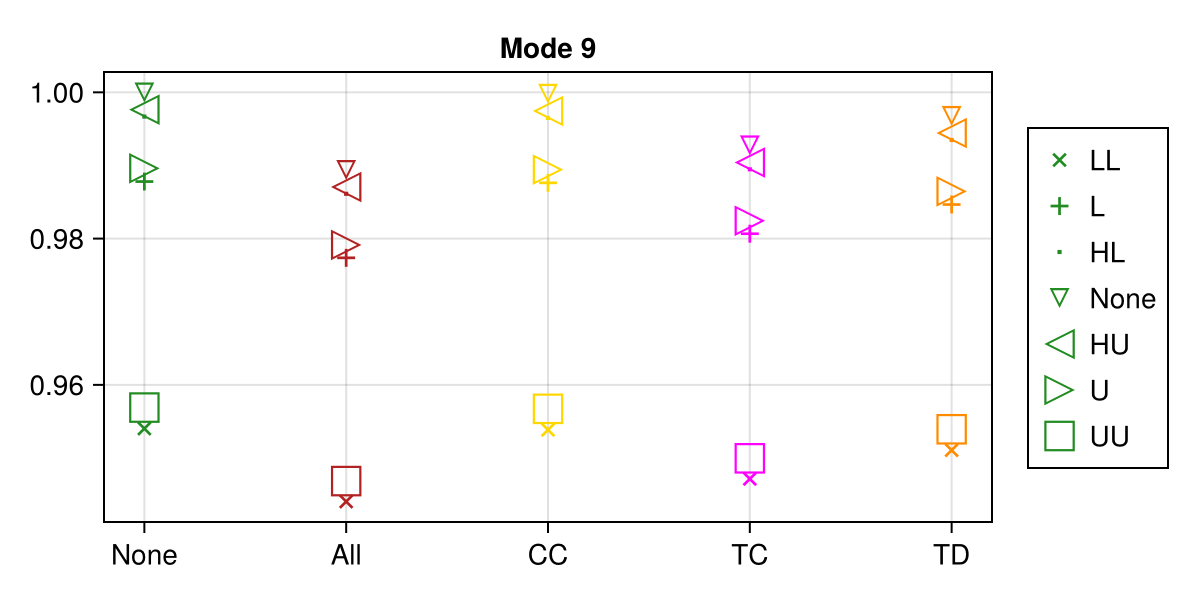

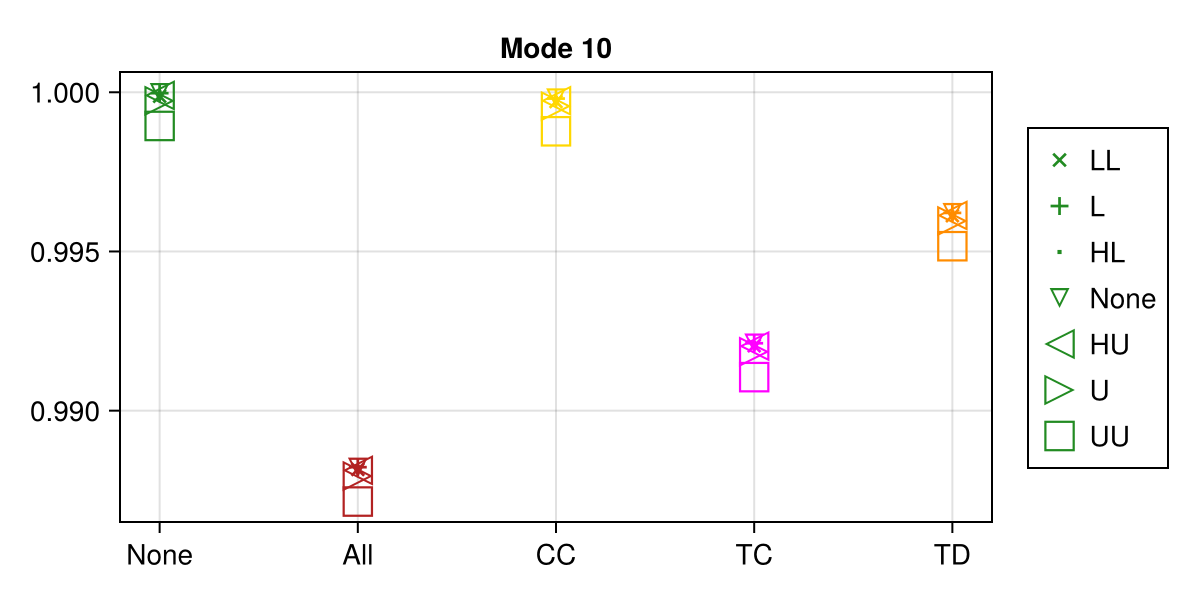

In [124]:
for mode in modes
    fig = cm.Figure(size = (600, 300))
    ax = cm.Axis(fig[1,1], title = "Mode $mode", xticks = ([0,1,2,3,4], ["None", "All", "CC", "TC", "TD"]))

    ψ = models[mode].dressed_states[(0,1)]
    x = [0]
    loss_colors = Dict{Any, Any}("None" => "forestgreen", "All" => "firebrick", "CC" => "gold", "TC" => "magenta", "TD" => "darkorange")
    drive_errors_markers = Dict{Any, Any}("LL" => '×', "L" => '+', "HL" => '.', "None" => '▿', "HU" => '◁', "U"=> '▷', "UU" => '□')
    dict_of_max = Dict{Any, Any}()

    losses_to_plot = ["None", "All", "CC", "TC", "TD"]

    for loss in losses_to_plot
        vals = []
        for de in drive_errors
            key = "Mode"*string(mode)*"_Loss_"*string(loss)*"_DE_"*string(de)
            push!(vals, (abs(qt.expect(data_dict[key]["states"][end], ψ))))
        end
        dict_of_max[loss] = maximum(vals)
    end
    xs = Dict{Any, Any}()
    for key in keys(drive_errors_markers)
        xs[key] = [0]
    end
    for combo in Iterators.product(losses_to_plot, drive_errors)
        key = "Mode"*string(mode)*"_Loss_"*string(combo[1])*"_DE_"*string(combo[2])
        #key_opt = "Mode"*string(mode)*"_Loss_"*string(combo[1])*"_DE_"*string("None")
        y = [(abs(qt.expect(data_dict[key]["states"][end], ψ)))]
        #y = (dict_of_max[combo[1]].-y)./dict_of_max[combo[1]]
        label = nothing
        if combo[1] == "None"
            label = combo[2]
        end

        cm.scatter!(ax, xs[combo[2]],y, label = label, marker = drive_errors_markers[combo[2]], color = loss_colors[combo[1]], markersize = 20)
        xs[combo[2]] = xs[combo[2]].+1
    end

    cm.Legend(fig[1,2], ax)


    display(fig)
end

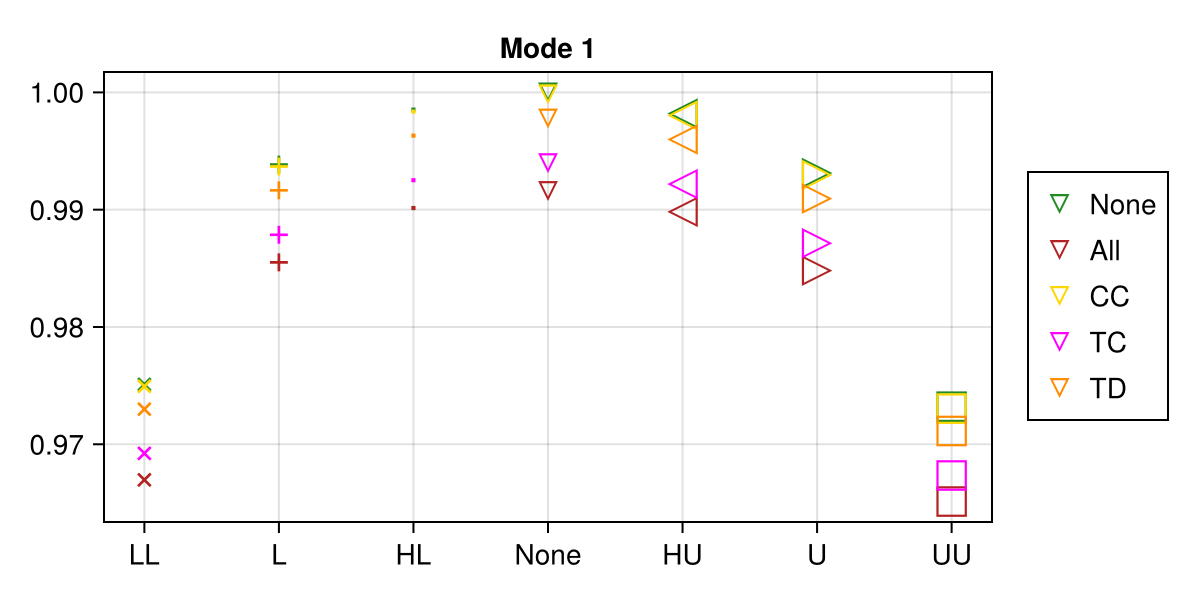

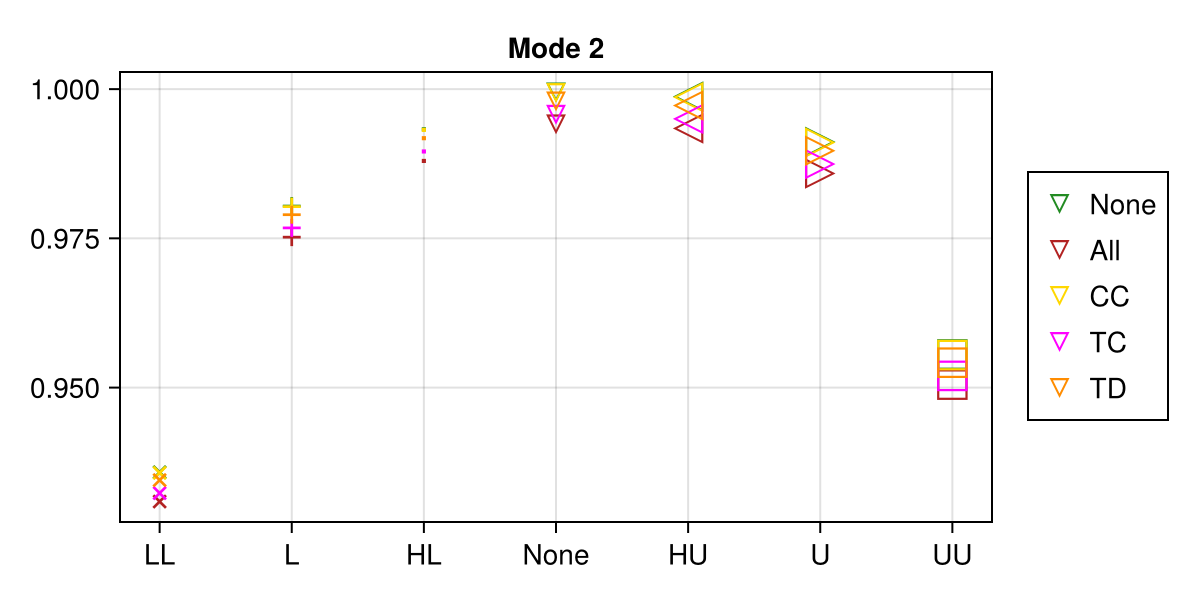

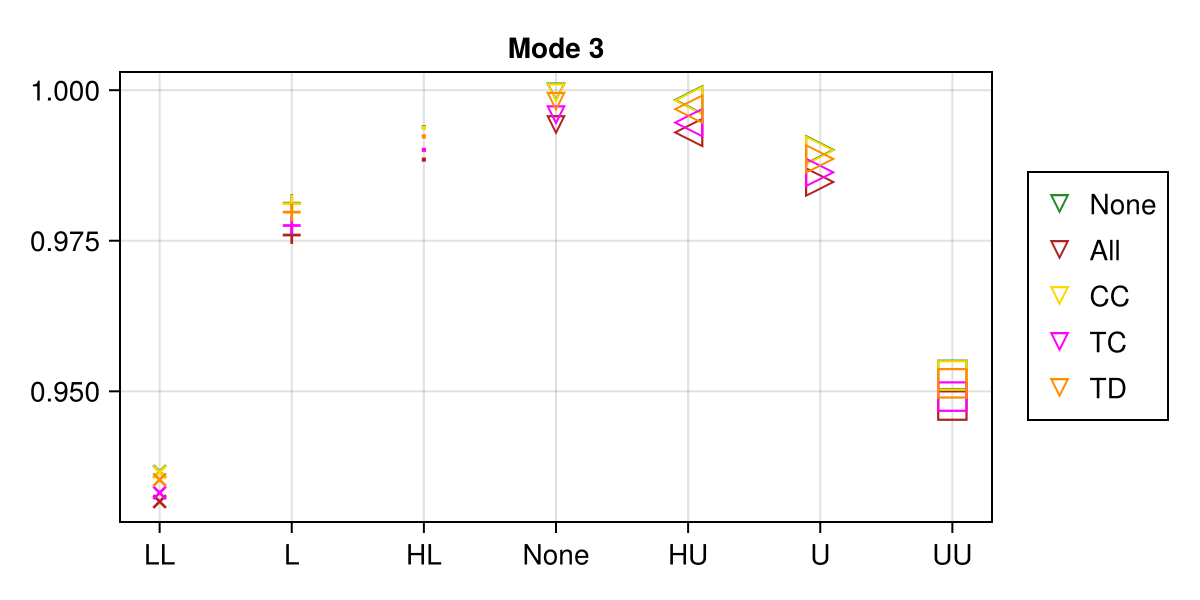

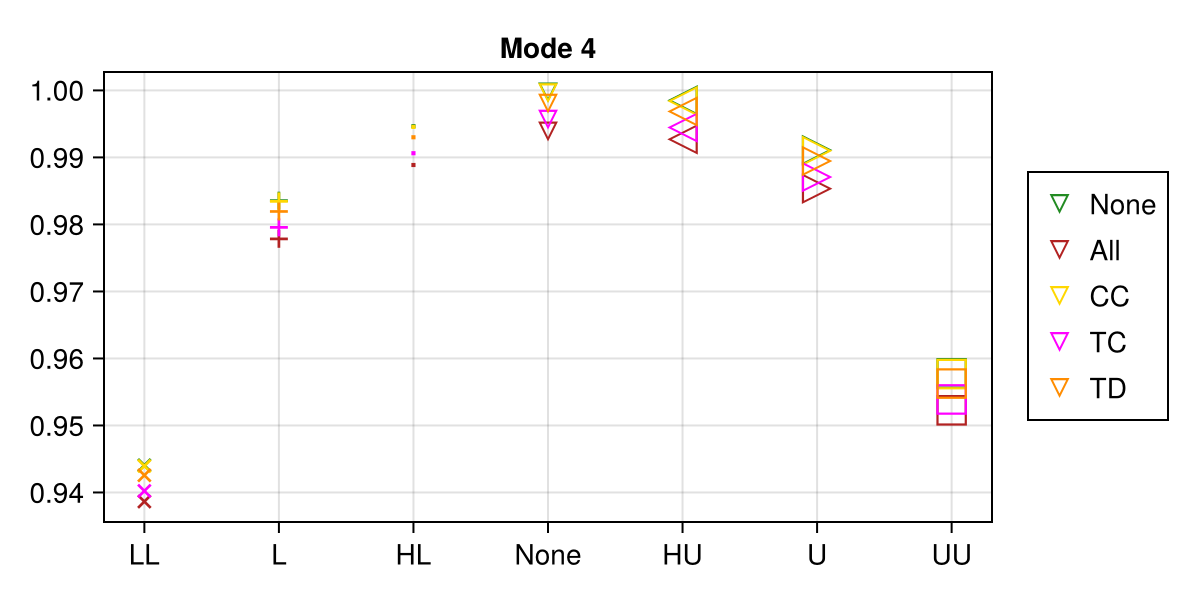

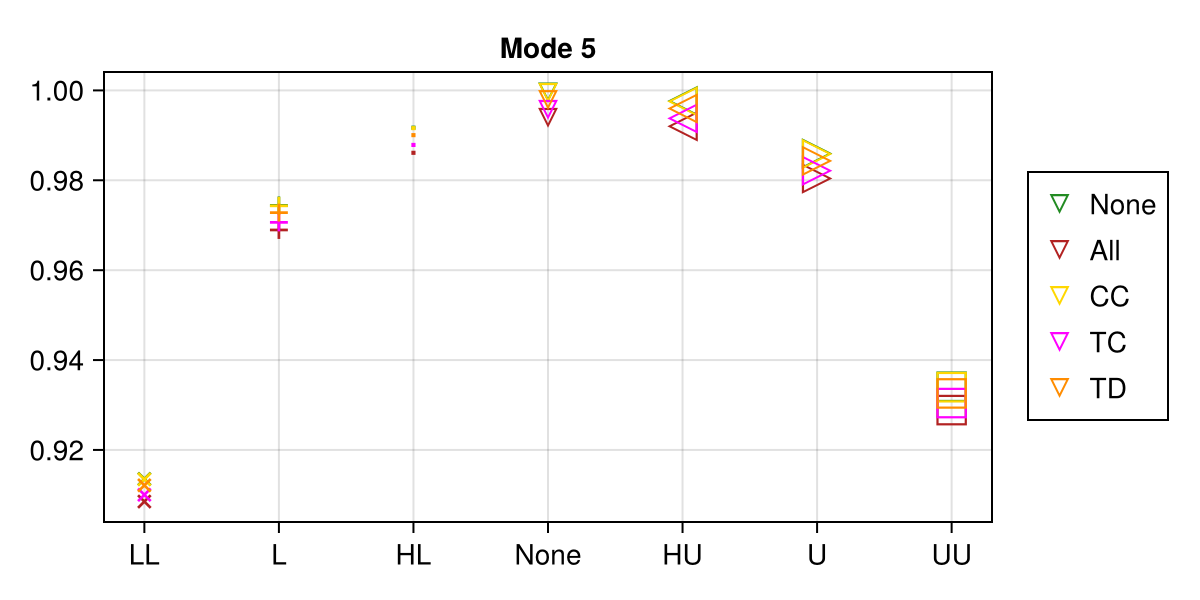

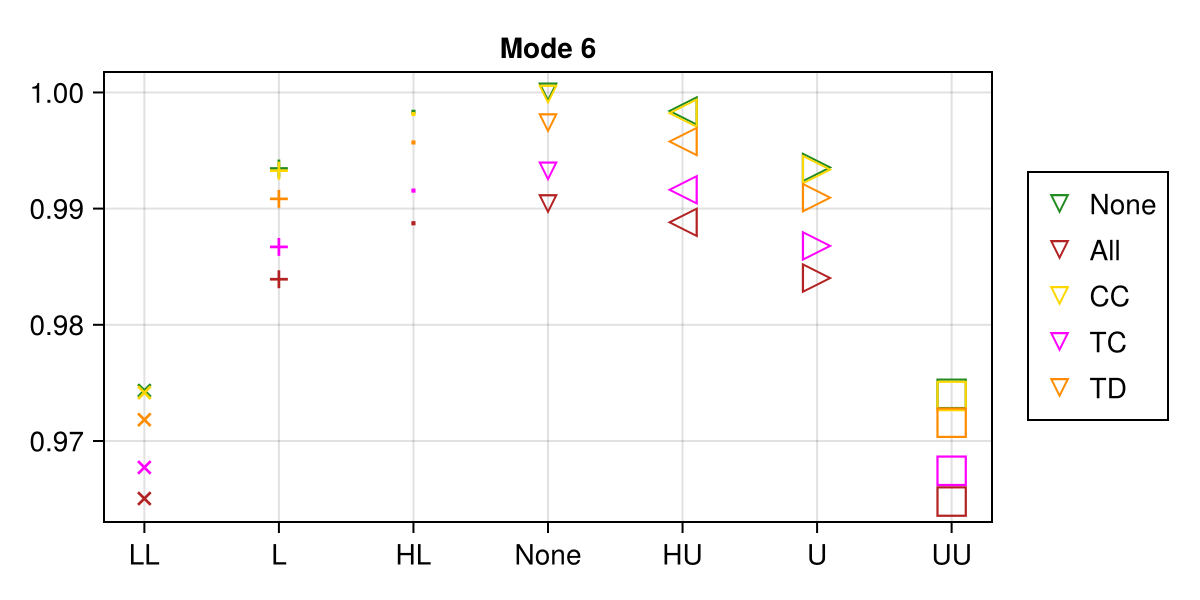

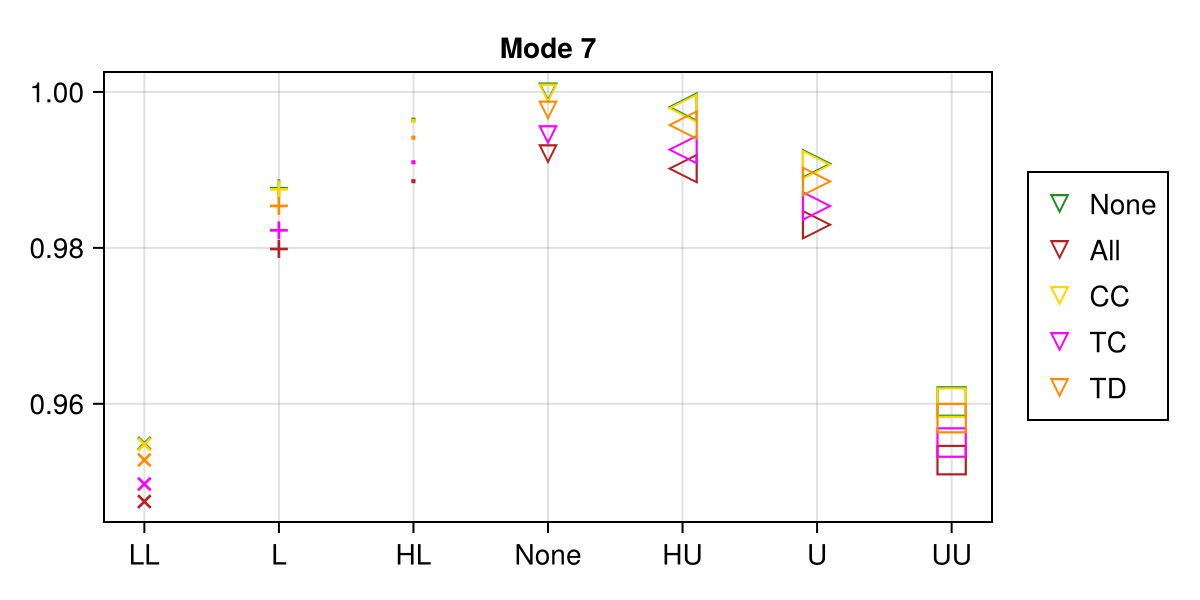

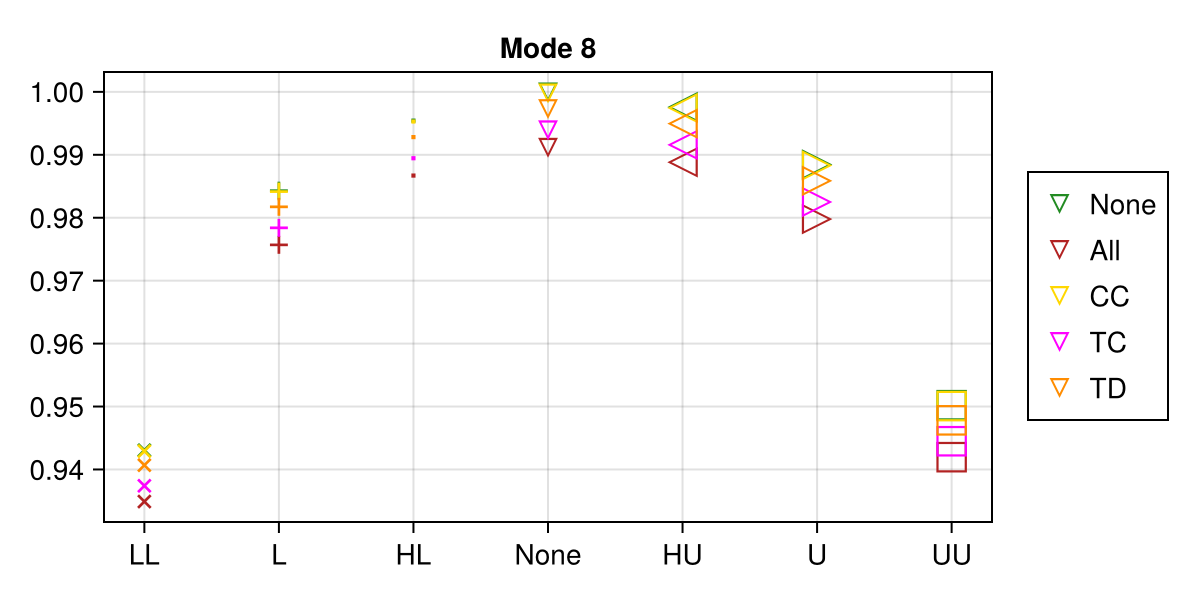

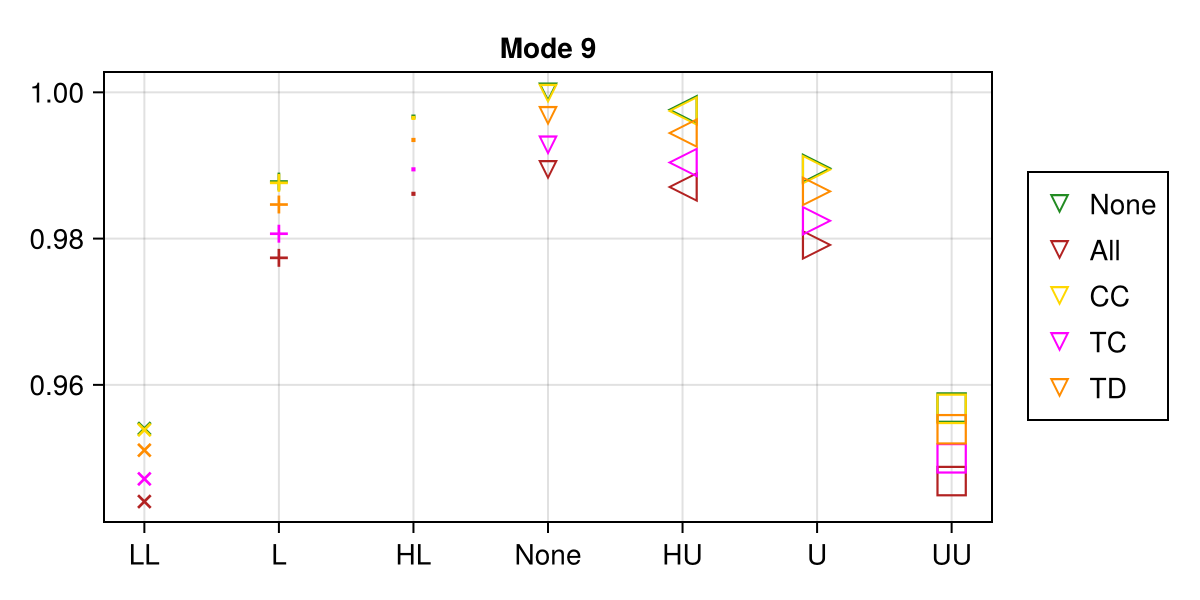

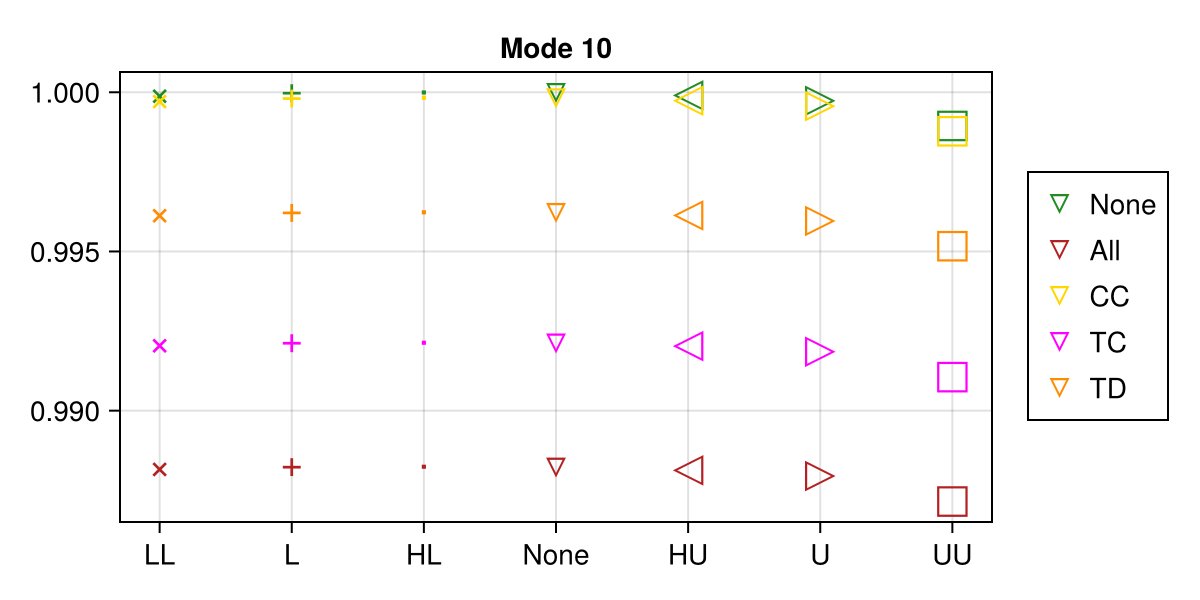

In [127]:
for mode in modes
    fig = cm.Figure(size = (600, 300))
    ax = cm.Axis(fig[1,1], title = "Mode $mode", xticks = ([0,1,2,3,4,5,6], ["LL", "L", "HL", "None", "HU", "U", "UU"]))

    ψ = models[mode].dressed_states[(0,1)]
    x = [0]
    loss_colors = Dict{Any, Any}("None" => "forestgreen", "All" => "firebrick", "CC" => "gold", "TC" => "magenta", "TD" => "darkorange")
    drive_errors_markers = Dict{Any, Any}("LL" => '×', "L" => '+', "HL" => '.', "None" => '▿', "HU" => '◁', "U"=> '▷', "UU" => '□')
    dict_of_max = Dict{Any, Any}()

    losses_to_plot = ["None", "All", "CC", "TC", "TD"]

    for loss in losses_to_plot
        vals = []
        for de in drive_errors
            key = "Mode"*string(mode)*"_Loss_"*string(loss)*"_DE_"*string(de)
            push!(vals, (abs(qt.expect(data_dict[key]["states"][end], ψ))))
        end
        dict_of_max[loss] = maximum(vals)
    end
    xs = Dict{Any, Any}()
    for key in keys(loss_colors)
        xs[key] = [0]
    end
    for combo in Iterators.product(losses_to_plot, drive_errors)
        key = "Mode"*string(mode)*"_Loss_"*string(combo[1])*"_DE_"*string(combo[2])
        #key_opt = "Mode"*string(mode)*"_Loss_"*string(combo[1])*"_DE_"*string("None")
        y = [(abs(qt.expect(data_dict[key]["states"][end], ψ)))]
        #y = (dict_of_max[combo[1]].-y)./dict_of_max[combo[1]]
        label = nothing
        if combo[2] == "None"
            label = combo[1]
        end

        cm.scatter!(ax, xs[combo[1]],y, label = label, marker = drive_errors_markers[combo[2]], color = loss_colors[combo[1]], markersize = 20)
        xs[combo[1]] = xs[combo[1]].+1
    end

    cm.Legend(fig[1,2], ax)


    display(fig)
end